# K-NN Classifier - Credit Risk Assessment

## Importing Libraries

In [235]:
import pandas as pd
import numpy as np

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt

## Setting Options

In [236]:
# set the option to display all columns
pd.set_option('display.max_columns', None)

## Loading Dataset

In [237]:
df = pd.read_csv('CreditRisk.csv', skipinitialspace=True)
display(df.head())

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


## Data Preprocessing

Finding duplicate rows.

In [239]:
df.duplicated(subset=None, keep='first').sum()

165

Dropping duplicate rows.

In [240]:
df.drop_duplicates(subset=None, keep='first', inplace=True)
df.duplicated(subset=None, keep='first').sum()

0

Finding missing values

In [241]:
df.isnull().sum(axis=0)

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

We see that there are 895 values missing from 'person_emp_length' column and 3116 values missing from 'loan_int_rate' column. 

'person_emp_length' column is employment length in years. Therefore, we will replace missing values in 'person_emp_length' with 0, assuming 0 means person is employed for less than a year. Similarly, we will replace missing values in 'loan_int_rate' column with minimum value of the column assuming the person is paying minimum interest rate since no loan is free and there must be some interest rate on any kind of loan. 

In [242]:
df['person_emp_length'].fillna(0, inplace=True)
df['loan_int_rate'].fillna(df['loan_int_rate'].min(), inplace=True)

In [243]:
df.isnull().sum(axis=0)

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

Now that there are no missing values from the dataset. Next we will check for outliers.

In [244]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32416.000000,3.241600e+04,32416.000000,32416.000000,32416.000000,32416.000000,32416.000000,32416.000000
mean,27.747008,6.609164e+04,4.659427,9593.845632,10.482852,0.218688,0.170250,5.811297
std,6.354100,6.201558e+04,4.162406,6322.730241,3.494406,0.413363,0.106812,4.059030
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.854200e+04,2.000000,5000.000000,7.490000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.620000,0.000000,0.150000,4.000000
75%,30.000000,7.921800e+04,7.000000,12250.000000,13.110000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


Description of the dataset shows that 'person_age' and 'person_emp_length' columns has outlier values. Maximum value in 'person_age' and 'person_emp_length' column is 144 and 123 respectively, which does not seem correct. We will stick to assessing credit risk of customers whose age and employment length is reasonable and not exceptional. Therefore, we will remove rows from our dataset where age and employment length of a person is greater than 85. Values in other columns seems correct and don't need fixing.

In [245]:
print(df.shape)
df.drop(df.index[(df.person_age > 85) | (df.person_emp_length > 85)], inplace=True)

(32416, 12)


In [246]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32408.000000,3.240800e+04,32408.000000,32408.000000,32408.000000,32408.000000,32408.000000,32408.000000
mean,27.728709,6.589557e+04,4.652061,9592.582078,10.482915,0.218711,0.170245,5.810541
std,6.199621,5.251816e+04,4.057471,6320.959306,3.494334,0.413379,0.106785,4.056254
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.490000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.620000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12250.000000,13.110000,0.000000,0.230000,8.000000
max,84.000000,2.039784e+06,41.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


Now, we can see that values in 'person_age' and 'person_emp_length' columns are reasonable. Let's check the amount of data loss when we dropped columns to fix outliers in the dataset.

In [247]:
df.shape

(32408, 12)

We can see that we have not lost much data, because before dropping rows we had 32416 rows and after dropping rows we are left with 32408 rows. We lost 8 rows, which means those rows that we deleted were outliers for sure. We are safe. 

Encoding Text Columns

Encoding text columns that contain categorical values with less than two categories to the appropriate numeric type. 

In [248]:
df['cb_person_default_on_file'], categories = pd.factorize(df['cb_person_default_on_file'])
print(categories)
print(df['cb_person_default_on_file'].unique())

Index(['N', 'Y'], dtype='object')
[0 1]


Encoding text columns that contain categorical values with more than two categories to dummy variables(one-hot encoded columns)

In [249]:
df = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade'])
display(df.head())

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
1,21,9600,5.0,1000,11.14,0,0.10,0,2,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,25,9600,1.0,5500,12.87,1,0.57,0,3,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,23,65500,4.0,35000,15.23,1,0.53,0,2,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
4,24,54400,8.0,35000,14.27,1,0.55,1,4,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
5,21,9900,2.0,2500,7.14,1,0.25,0,2,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0


Since 'loan_status' is the output variable, we need to make it last column in the pandas dataframe to organize our understanding of this assessment.

In [250]:
date_col = df.pop('loan_status')
df.insert(len(df.columns), 'loan_status', date_col)
display(df.head())

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,loan_status
1,21,9600,5.0,1000,11.14,0.10,0,2,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,25,9600,1.0,5500,12.87,0.57,0,3,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
3,23,65500,4.0,35000,15.23,0.53,0,2,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
4,24,54400,8.0,35000,14.27,0.55,1,4,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
5,21,9900,2.0,2500,7.14,0.25,0,2,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1


## Partitioning Dataset

We dropped several rows from dataframe above and moved 'loan_status' a column to the end of the dataframe. This deletion of rows might cause indexing errors. Therefore, to avoid any indexing errors we need to rebuild the index to avoid any indexing errors down the line. 

In [251]:
df.reset_index(inplace=True, drop=True)

Partitioning the dataset into the training, validation, and test sets (60%:40%).

In [252]:
trainData, validData = train_test_split(df, test_size=0.4, random_state=26)

## Normalizing Dataset

In [253]:
scaler = preprocessing.StandardScaler()
scaler.fit(trainData.iloc[:, :-1]) 

# Transform the full dataaset 
dfNorm = pd.concat([pd.DataFrame(
    scaler.transform(df.iloc[:, :-1]), 
    columns= df.columns.tolist()[:-1]),
                       df[['loan_status']]], axis=1)

display(dfNorm.head())

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,loan_status
0,-1.082295,-1.061080,0.086492,-1.362889,0.183564,-0.653623,-0.467711,-0.939835,-0.836007,-0.057915,3.413300,-1.012524,-0.437267,2.025027,-0.348707,-0.480243,-0.451045,-0.466241,-0.699891,1.450889,-0.498569,-0.352407,-0.174879,-0.087876,-0.047624,0
1,-0.434045,-1.061080,-0.904229,-0.644355,0.679417,3.738993,-0.467711,-0.691075,1.196162,-0.057915,-0.292972,-1.012524,-0.437267,-0.493821,-0.348707,2.082281,-0.451045,-0.466241,-0.699891,-0.689233,2.005740,-0.352407,-0.174879,-0.087876,-0.047624,1
2,-0.758170,-0.004738,-0.161188,4.066036,1.355841,3.365153,-0.467711,-0.939835,-0.836007,-0.057915,-0.292972,0.987630,-0.437267,-0.493821,-0.348707,2.082281,-0.451045,-0.466241,-0.699891,-0.689233,2.005740,-0.352407,-0.174879,-0.087876,-0.047624,1
3,-0.596108,-0.214495,0.829533,4.066036,1.080686,3.552073,2.138071,-0.442315,-0.836007,-0.057915,-0.292972,0.987630,-0.437267,-0.493821,-0.348707,2.082281,-0.451045,-0.466241,-0.699891,-0.689233,2.005740,-0.352407,-0.174879,-0.087876,-0.047624,1
4,-1.082295,-1.055411,-0.656549,-1.123378,-0.962917,0.748275,-0.467711,-0.939835,-0.836007,-0.057915,3.413300,-1.012524,-0.437267,-0.493821,-0.348707,-0.480243,-0.451045,2.144815,1.428794,-0.689233,-0.498569,-0.352407,-0.174879,-0.087876,-0.047624,1


In [254]:
trainNorm = dfNorm.iloc[trainData.index]
validNorm = dfNorm.iloc[validData.index]

## Finding Best Value of K

Finding choice of k that balances between overfitting and ignoring the predictor information. Trying out k = 1 to k = 15.

In [255]:
train_X = trainNorm.drop('loan_status', axis=1)
train_y = trainNorm['loan_status']
valid_X = validNorm.drop('loan_status', axis=1)
valid_y = validNorm['loan_status']

# Train a classifier for different values of k
results = []
for k in range(1, 16):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })
    
# Convert results to a pandas data frame
results = pd.DataFrame(results)
display(results)

,k,accuracy
0,1,0.855446
1,2,0.882829
2,3,0.885221
3,4,0.889926
4,5,0.891237
5,6,0.891623
6,7,0.891700
7,8,0.890543
8,9,0.893243
9,10,0.891160


## Result

From above table we see that accuracy is best when k = 8. Therefore, when we use k = 8, we will get the best classification performance. Choice of k = 8 will balance between overfitting and ignoring the predictor information. If we choose value of k that is less than 8, then we will classify in a way that is very sensitive to the local characteristics of the training data. Likewise, if we choose a very large value of k, such as k = 15, we sould simply predict the most frequent class in the dataset in all cases. K = 15 would be very stable prediction but it will completely ignore the information in the predictors.

## Confusion Matrix

Displaying the confusion matrix for the validation data that results from using the best k. In our case, it is k = 8.

In [256]:
knn = KNeighborsClassifier(n_neighbors=8).fit(train_X, train_y)
predicted = knn.predict(valid_X)

cm = confusion_matrix(valid_y, predicted)
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[9966  161]
 [1258 1579]]


Defining method to find counts of Actual and Predicted values so that we can label the axes correctly while plotting confusion matrix.

In [257]:
def findOutputCounts(actual, predicted):   
    assert isinstance(actual, np.ndarray), "Argument 'actual' must be a numpy array."
    assert isinstance(predicted, np.ndarray), "Argument 'predicted' must be a numpy array."
    
    print('Actual Value Counts')
    print('Total Element Count: {}'.format(len(actual)))
    print('Not Default Count: {}'.format(len(actual[actual == 0])))
    print('Default Count: {}'.format(len(actual[actual == 1])))

    print('\nPredicted Value Counts')
    print('Total Element Count: {}'.format(len(predicted)))
    print('Not Default Count: {}'.format(len(predicted[predicted == 0])))
    print('Default Count: {}'.format(len(predicted[predicted == 1])))

In [258]:
findOutputCounts(valid_y.to_numpy(), predicted)

Actual Value Counts
Total Element Count: 12964
Not Default Count: 10127
Default Count: 2837

Predicted Value Counts
Total Element Count: 12964
Not Default Count: 11224
Default Count: 1740


Combining information from above confusion matrix and value counts we can conclude following about labels of axes in plot of confusion matrix. 

1. Sum of values in top row of confusion matrix above (9966 + 161) = 10127, which is Not Default Count of Actual values as calculated above. Therefore, in the plot below, on the y-axis, where we display Acutal counts, the label of top row will be 'Not Default'. If the label of top row is 'Not Default' then label of bottom row will be 'Default'.

2. Likewise, Sum values in the first column of confusion matrix above (9966 + 1258) = 11224, which is Not Default Count of Predicted values as calculated above. Therefore, in the plot below, on the x-axis, where we display Predicted counts, the label of first column will be 'Not Default'. If the label of first column is 'Not Default', then the label of second column will be 'Default'.

Defining method to plot confusion matrix

In [260]:
def PlotConfusionMatrix(cm):
    fig, ax = plt.subplots()
    im = ax.imshow(cm)

    # Showing all ticks and labelling them with the respective list entries
    ax.set_xticks(np.arange(2), labels=['Not Default', 'Default'])
    ax.set_yticks(np.arange(2), labels=['Not Default', 'Default'])

    # Setting labels for x-axis and y-axis
    ax.set_xlabel('Predicted', fontsize=13)
    ax.set_ylabel('Actual', fontsize=13)

    # Creating text annotations.
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, cm[i, j], color='r')

    ax.set_title('Confusion Matrix', fontsize=15)
    fig.tight_layout()
    plt.show()

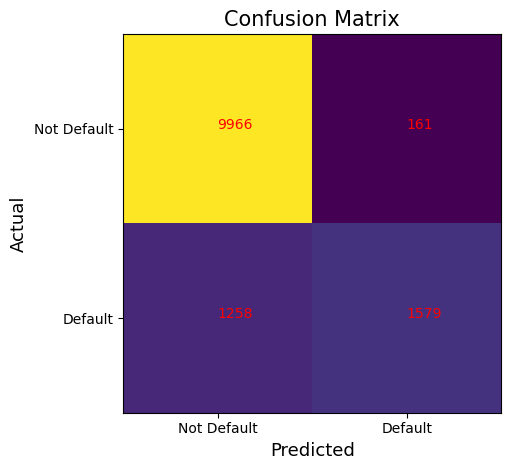

In [261]:
PlotConfusionMatrix(cm)

## Repartitioning Data

Repartitioning the data, this time into training, validation, and test sets (50%:30%:20%).

In [262]:
trainNorm, remainingNorm = train_test_split(dfNorm, test_size=0.5, random_state=26)
print(trainNorm.shape)
print(remainingNorm.shape)

(16204, 26)
(16204, 26)


In [263]:
validNorm, testNorm = train_test_split(remainingNorm, test_size=0.4, random_state=26)
print(validNorm.shape)
print(testNorm.shape)

(9722, 26)
(6482, 26)


In [264]:
train_X = trainNorm.drop('loan_status', axis=1)
train_y = trainNorm['loan_status']
valid_X = validNorm.drop('loan_status', axis=1)
valid_y = validNorm['loan_status']
test_X = testNorm.drop('loan_status', axis=1)
test_y = testNorm['loan_status']

## K-NN Classification (K = 8)

In [265]:
knn = KNeighborsClassifier(n_neighbors=8).fit(train_X, train_y)

Computing confusion matrix on training data

In [266]:
predicted = knn.predict(train_X)

cm = confusion_matrix(train_y, predicted)
print('Accuracy Score: ', accuracy_score(train_y, predicted))
print('Confusion Matrix')
print(cm)

Accuracy Score:  0.9051468773142434
Confusion Matrix
[[12519   128]
 [ 1409  2148]]


In [267]:
findOutputCounts(train_y.to_numpy(), predicted)

Actual Value Counts
Total Element Count: 16204
Not Default Count: 12647
Default Count: 3557

Predicted Value Counts
Total Element Count: 16204
Not Default Count: 13928
Default Count: 2276


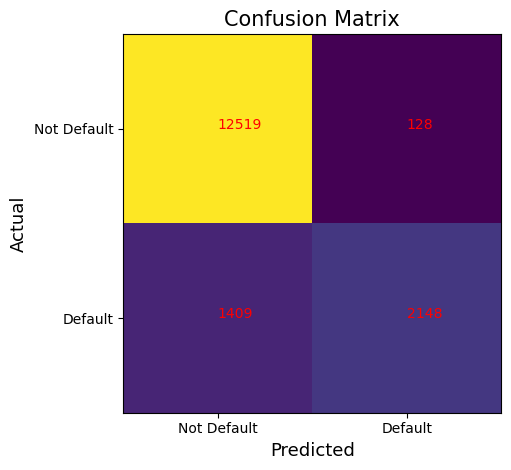

In [268]:
PlotConfusionMatrix(cm)

Computing confusion matrix on validation data

In [270]:
predicted = knn.predict(valid_X)

cm = confusion_matrix(valid_y, predicted)
print('Accuracy Score: ', accuracy_score(valid_y, predicted))
print('Confusion Matrix')
print(cm)

Accuracy Score:  0.8876774326270315
Confusion Matrix
[[7486  141]
 [ 951 1144]]


In [271]:
findOutputCounts(valid_y.to_numpy(), predicted)

Actual Value Counts
Total Element Count: 9722
Not Default Count: 7627
Default Count: 2095

Predicted Value Counts
Total Element Count: 9722
Not Default Count: 8437
Default Count: 1285


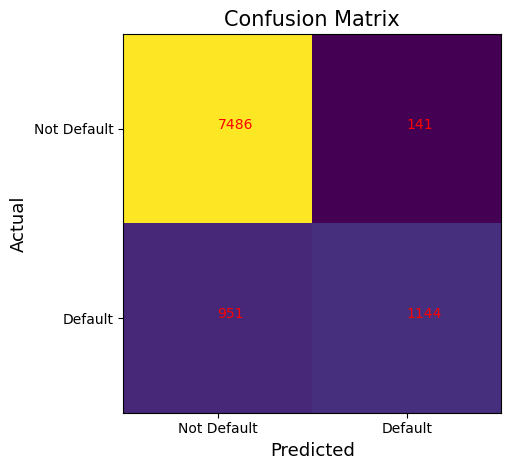

In [272]:
PlotConfusionMatrix(cm)

Computing confusion matrix on test data

In [273]:
predicted = knn.predict(test_X)

cm = confusion_matrix(test_y, predicted)
print('Accuracy Score: ', accuracy_score(test_y, predicted))
print('Confusion Matrix')
print(cm)

Accuracy Score:  0.8903116322122802
Confusion Matrix
[[4958   88]
 [ 623  813]]


In [274]:
findOutputCounts(test_y.to_numpy(), predicted)

Actual Value Counts
Total Element Count: 6482
Not Default Count: 5046
Default Count: 1436

Predicted Value Counts
Total Element Count: 6482
Not Default Count: 5581
Default Count: 901


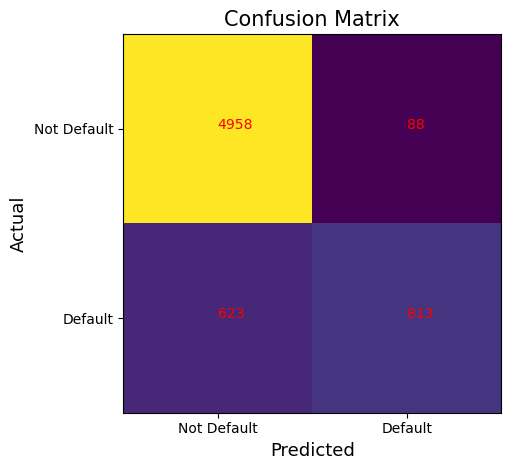

In [275]:
PlotConfusionMatrix(cm)

## Result

The diagonal elements of the confusion matrix represent the correct predictions, while the off-diagonal elements represent the errors. You want to have high values on the diagonal and low values on the off-diagonal. If we compare confusion  matrix on the test dataset with that on training and validation dataset, we see that, in the test set diagonal elements have high values and off-diagonal elements have low values compared to diagonal and non-diagonal values of confusion matrices on validation and training datasets. This means our algorighm is doing well while classifying. 

In addition, first, accuracy on validation data (accuracy = 0.8876774326270315) and test data (accuracy = 0.8903116322122802) is less than accuracy on training data (accuracy = 0.9051468773142434). This is the desired result and this means our algorithm is doing well and selection of k = 8 is correct. Less accuracy on validation and test data compared to accuracy on training data means, algorithm is not overfitting, which is a good thing. This is apparent, because, since algorithm was trained on training data, accuracy on training data will be higher because algorithm has already seen the data. Accuracy on validation and test data is less than training data because algorithm made prediction on data that the algorithm has not seen before, therefore, decrease in accuracy is expected and desired. 

Secondly, accuracy on validation and test data is not very low, it is still high and very close to 90%. This means our algorithm is not underfitting. 

Further, difference between accuracy on validation and test data is not huge. They are not equal and they are very close. We need this difference because algorithm is working on two different datasets and we do expect a difference in accuracy.